In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### 본 문서는 아래 자료를 참고하여 작성하였습니다.
https://kaggle-kr.tistory.com/17?category=868316

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/tmp/ipykernel_19/4083208389.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


앞으로 우리가 해야할 프로세스는 대략 아래와 같습니다.

1. 데이터셋 확인 - 대부분의 캐글 데이터들은 잘 정제되어 있습니다. 하지만 가끔 null data가 존재합니다. 이를 확인하고, 향후 수정합니다.
2. 탐색적 데이터 분석(exploratory data analysis) - 여러 feature들을 개별적으로 분석하고, feature 들 간의 상관관계를 확인합니다. 여러 시각화 툴을 사용하여 insight를 얻습니다.
3. feature engineering - 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature들을 engineering 합니다. one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등을 합니다.
4. model 만들기 - sklearn을 사용해 모델을 만듭니다. 파이썬에서 머신러닝을 할 때는 sklearn을 사용하면 수많은 알고리즘을 일관된 문법으로 사용할 수 있습니다. 물론 딥러닝을 위해 tensorflow, pytorch 등을 사용할 수도 있습니다.
5. 모델 학습 및 예측 - trainset을 가지고 모델을 학습시킨 후, testset을 가지고 prediction 합니다.
6. 모델 평가 - 예측 성능이 원하는 수준인지 판단합니다. 풀려는 문제에 따라 모델을 평가하는 방식도 달라집니다. 학습된 모델이 어떤 것을 학습하였는 지 확인해봅니다.

## 1. Dataset 확인
- 파이썬에서 테이블화 된 데이터를 다루는 데 가장 최적화되어 있으며, 많이 쓰이는 라이브러리는 pandas 입니다.
- 우리는 pandas를 사용하여 데이터셋의 간단한 통계적 분석부터, 복잡한 처리들을 간단한 메소드를 사용하여 해낼 수 있습니다.
- 파이썬으로 데이터분석을 한다고 하면 반드시 능숙해져야 할 라이브러리이니, 여러 커널들을 공부하시면서 사용법에 익숙해지도록 반복 또 반복하시길 권장합니다.
- 캐글에서 데이터셋은 보통 train, testset으로 나뉘어 있습니다.

In [3]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- 우리가 다루는 문제에서 feature는 Pclass, Age, SibSp, Parch, Fare이며, 예측하려는 target label은 Survived입니다.
- pandas dataframe에는 describe() 메소드가 있는 데, 이를 쓰면 각 feature가 가진 통계치들을 반환해줍니다.

In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


- 테이블에서 보다시피, PassenserID 숫자와 다른, 그러니까 null data가 존재하는 열(feature)가 있는 것 같습니다.
- 이를 좀 더 보기 편하도록 그래프로 시각화해서 살펴봅시다.

### 1.1 Null data check

In [7]:
for col in df_train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(
    col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:   Survived	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 19.87%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.00%
column:      Cabin	 Percent of NaN value: 77.10%
column:   Embarked	 Percent of NaN value: 0.22%


In [8]:
for col in df_test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(
    col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 20.57%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.24%
column:      Cabin	 Percent of NaN value: 78.23%
column:   Embarked	 Percent of NaN value: 0.00%


- Train, Test set에서 Age(둘 다 약 20%), Cabin(둘 다 약 80%), Embarked(Train만 0.22%) null data 존재하는 것을 볼 수 있습니다.
- MANO라는 라이브러리를 사용하면 null data의 존재를 더 쉽게 볼 수 있습니다.

<Axes: >

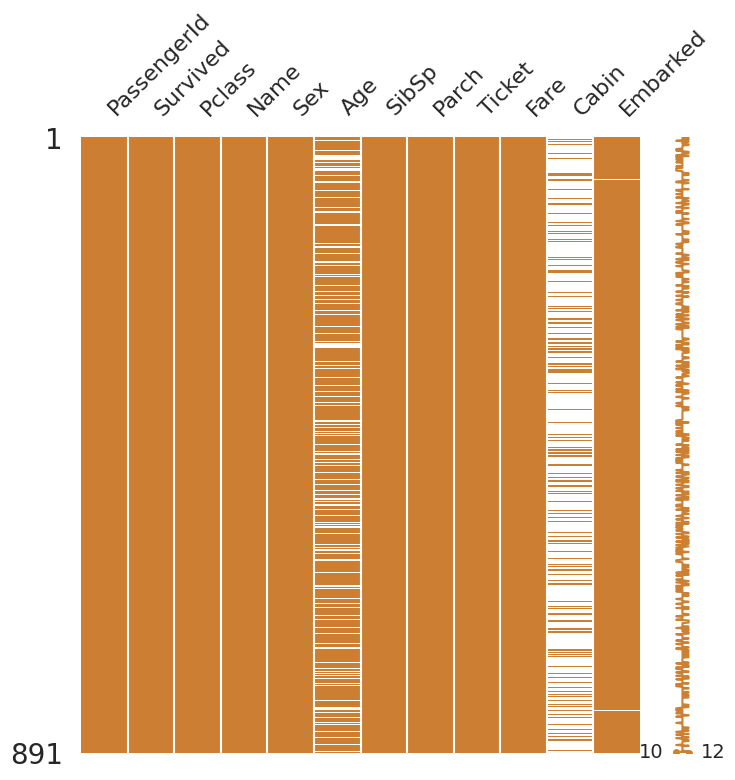

In [9]:
msno.matrix(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

<Axes: >

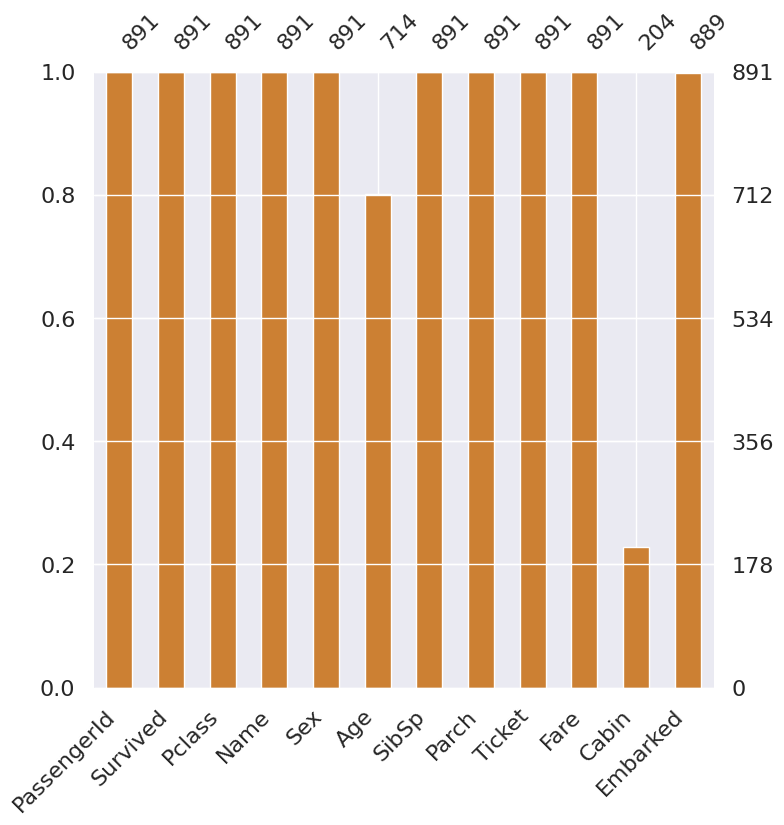

In [10]:
msno.bar(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

<Axes: >

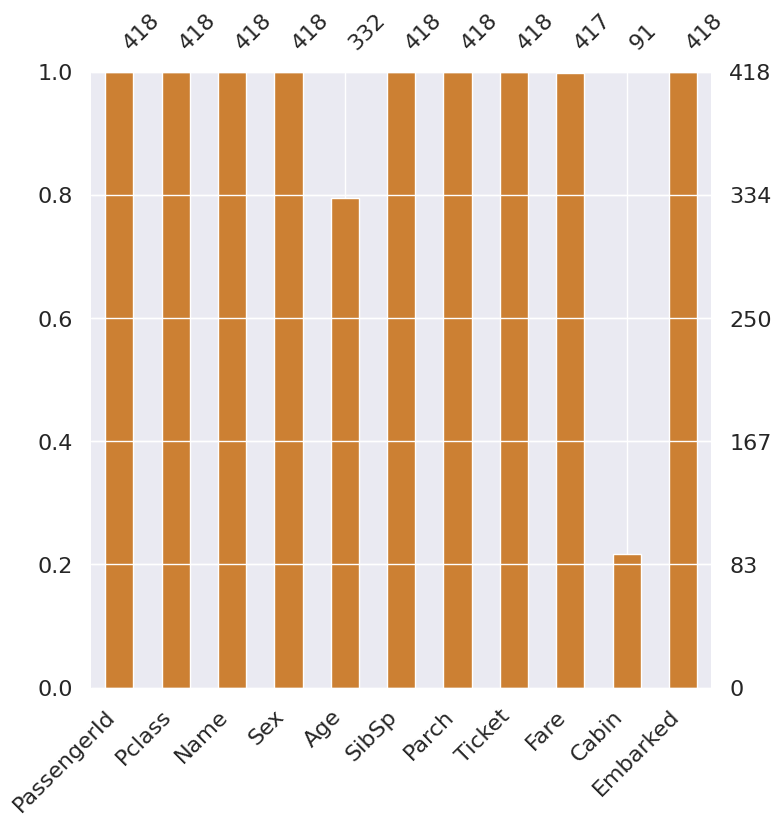

In [11]:
msno.bar(df=df_test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

### 1.2 Target label 확인
- target label이 어떤 distribution을 가지고 있는 지 확인해봐야 합니다.
- 지금 같은 binary classification 문제의 경우에서, 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있습니다.

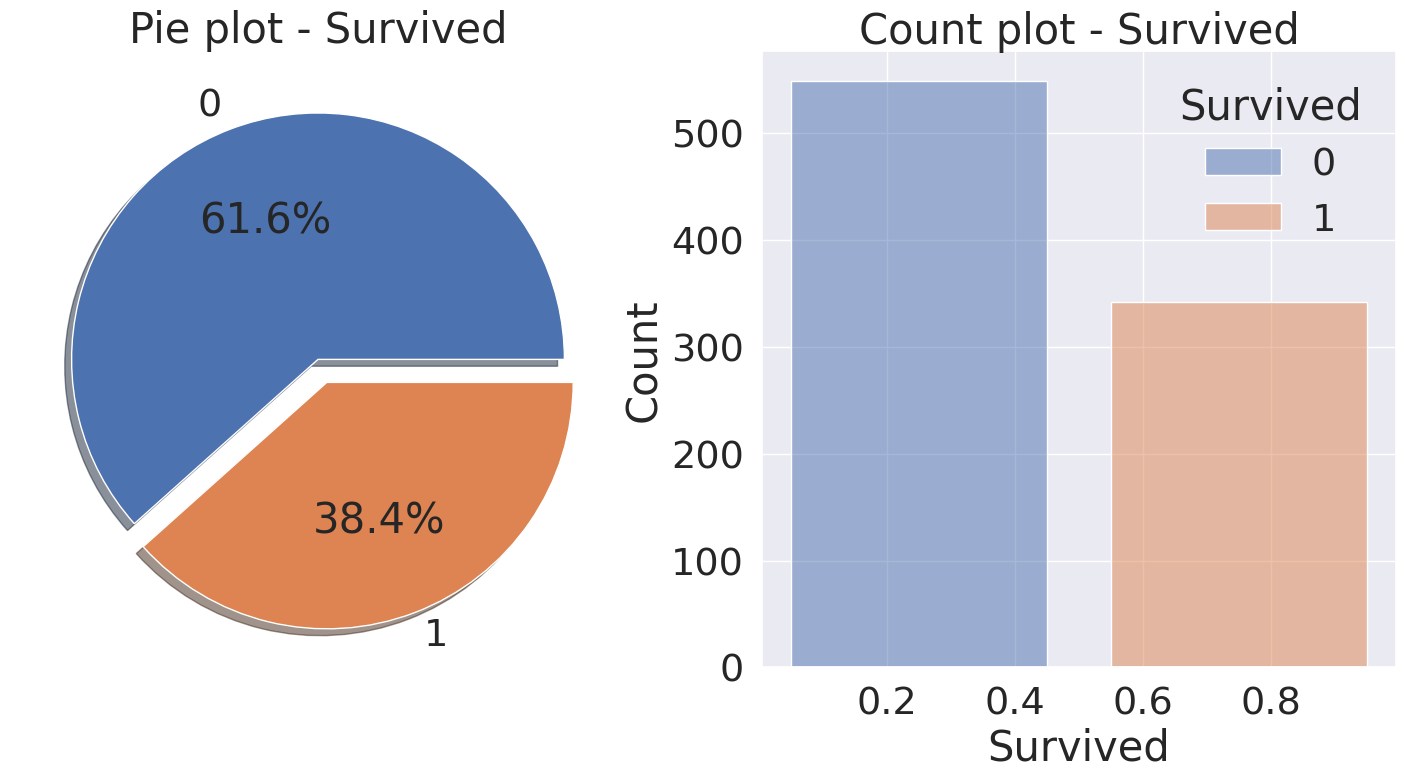

In [12]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Survived'].value_counts().plot.pie(
    explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.histplot(df_train, x='Survived', hue='Survived', ax=ax[1], bins=2, shrink=0.8)
ax[1].set_title('Count plot - Survived')

plt.show()

- 안타깝게도 죽은 사람이 많습니다.
- 38.4%가 살아남았습니다.
- target label의 분포가 제법 균일(balanced)합니다. 불균일한 경우, 예를 들어서 100중 1이 99, 0이 1개인 경우에는 만약 모델이 모든것을 1이라 해도 정확도는 99%가 나오게 됩니다. 0을 찾는 문제라면 이 모델은 원하는 결과를 줄 수 없게 됩니다. 지금 문제에서는 그렇지 않으니 계속 진행하겠습니다.

## 2. Exploratory data analysis
- 이제 본격적으로 데이터 분석을 해보겠습니다. 데이터는 매우 많습니다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요합니다.
- 시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있습니다. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편합니다.

### 2.1 Pclass
- 먼저 Pclass에 대해서 살펴보겠습니다. Pclass는 ordinal, 서수형 데이터입니다. 카테고리이면서, 순서가 있는 데이터 타입입니다.
- 먼저 Pclass에 따른 생존률의 차이를 살펴보겠습니다. 엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas dataframe에서는 groupby를 사용하면 쉽게 할 수 있습니다. 또한 pivot이라는 메소드도 있습니다.
- 'Pclass', 'Survived'를 가져온 후, pclass로 묶습니다. 그러고 나면 각 pclass마다 0, 1이 count되는데, 이를 평균내면 각 pclass별 생존률이 나옵니다.
- 아래와 같이 count()를 하면, 각 class에 몇 명이 있는 지 확인할 수 있으며, sum()을 하면, 216명 중 생존한(survived=1) 사람의 총합을 주게 됩니다.

In [13]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [14]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


- pandas의 crosstab을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있습니다.

In [15]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


- grouped 객체에 mean()을 하게 되면, 각 클래스려 생존률을 얻을 수 있습니다. class가 1이면 아래와 같습니다.

<Axes: xlabel='Pclass'>

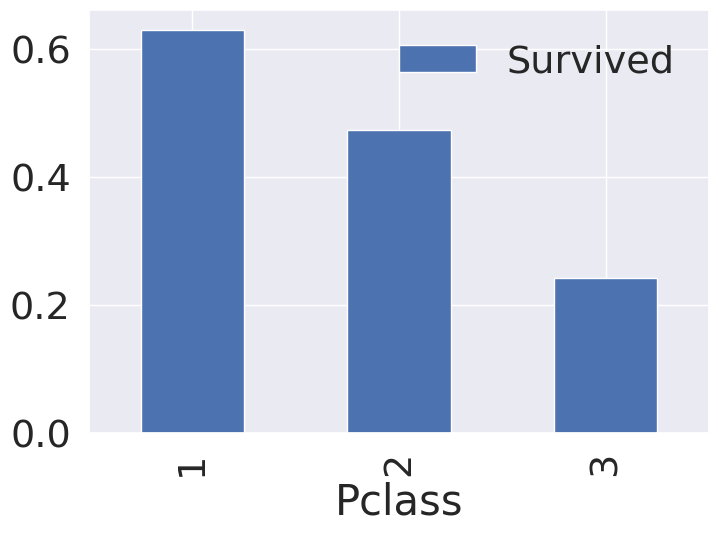

In [16]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()

- 보다시피시, Pclass가 좋을수록(1st) 생존률이 높은 것을 확인할 수 있습니다.
- 좀 더 보기 쉽게 그래프를 그려보겠습니다. seaborn의 countplot을 이용하면, 특정 label에 따른 개수를 확인해볼 수 있습니다.

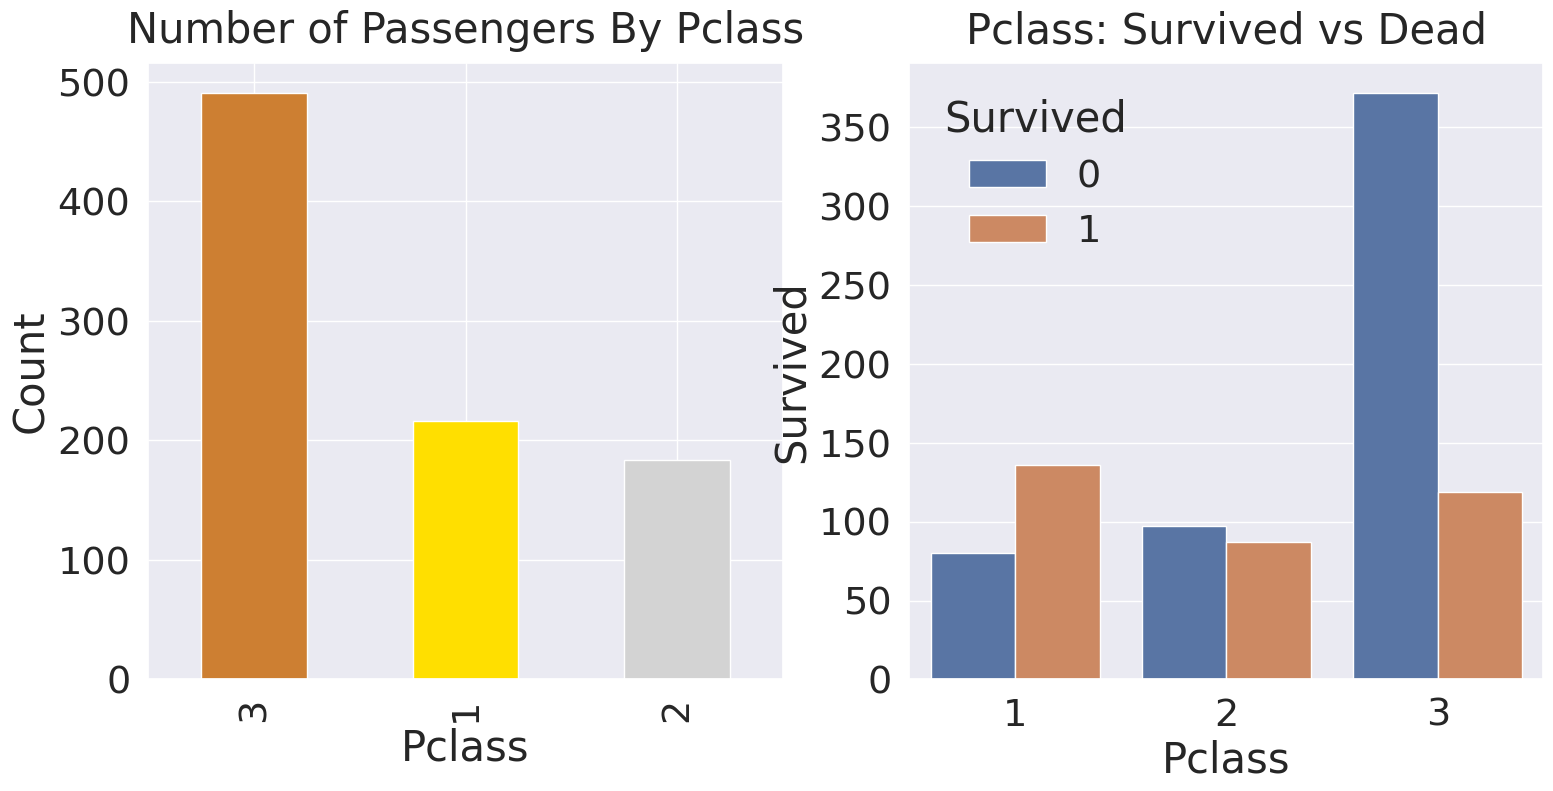

In [17]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32', '#FFDF00', '#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass', y=y_position)
ax[0].set_ylabel('Count')
sns.barplot(df_train, x='Pclass', y='Survived', estimator=len, hue='Survived', ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

- 클래스가 높을 수록, 생존 확률이 높은 걸 확인할 수 있습니다. Pclass 1, 2, 3 순서대로 63%, 48%, 25% 입니다.
- 우리는 생존에 Pclass가 큰 영향을 미친다고 생각해 볼 수 있으며, 나중에 모델을 세울 때 이 feature을 사용하는 것이 좋을 것이라 판단할 수 있습니다.

### 2.2 Sex
- 이번에는 성별로 생존률이 어떻게 달라지는 지 확인해보겠습니다.
- 마찬가지로 pandas groupby와 seaborn countplot을 사용해서 시각화해봅시다.

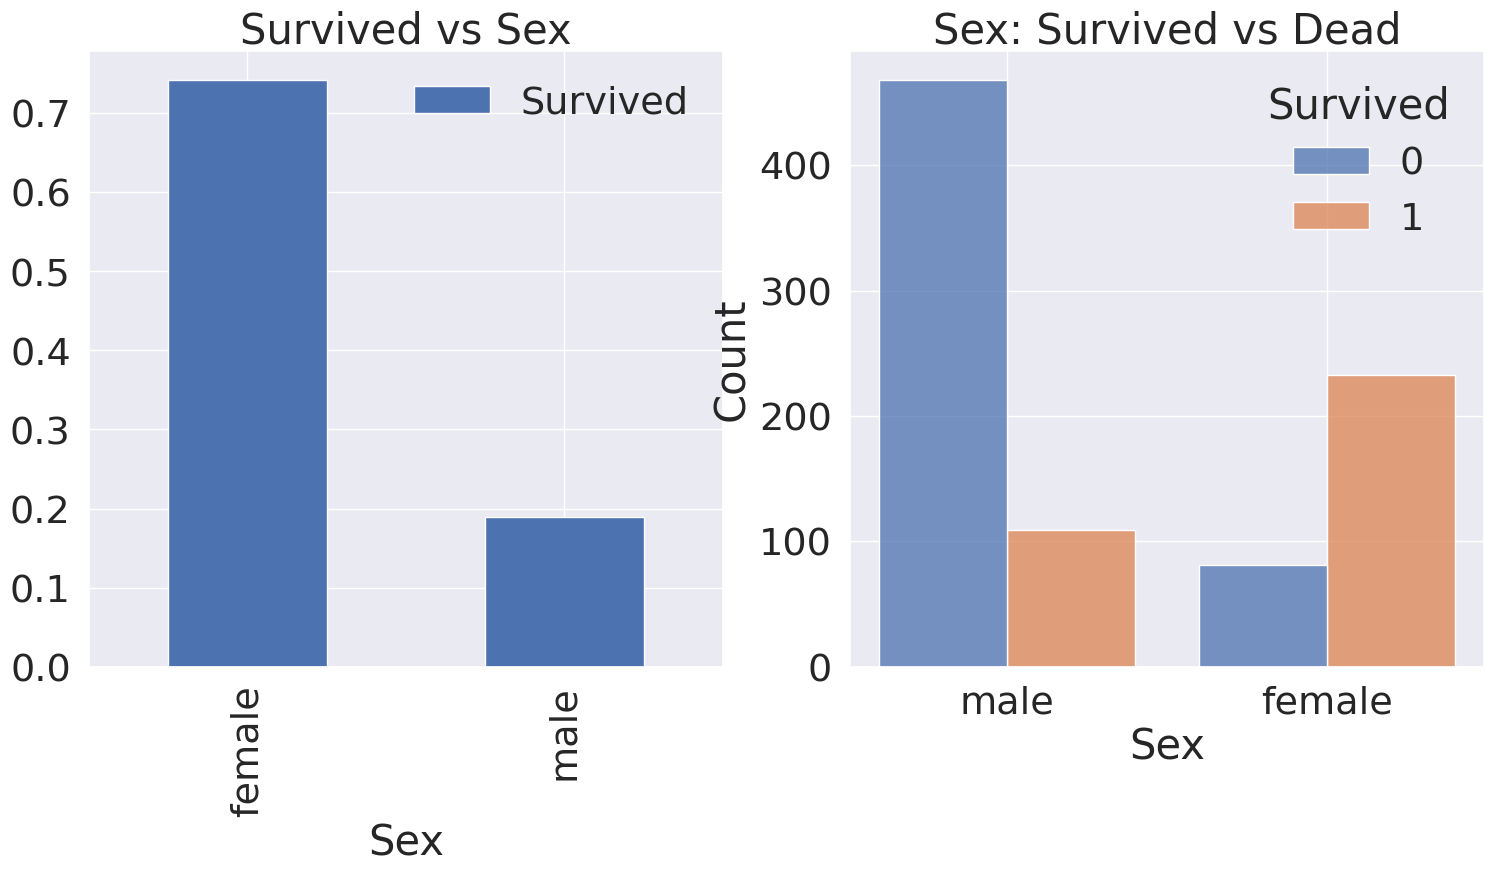

In [18]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.histplot(data=df_train, x='Sex', hue='Survived', multiple='dodge', shrink=0.8, ax=ax[1], bins=2)
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

- 보시다시피, 여자가 생존할 확률이 높습니다.

In [19]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [20]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


- Pclass와 마찬가지로, Sex도 예측 모델에 쓰일 중요한 feature임을 알 수 있습니다.

### 2.3 Both Sex and Pclass
- 이번에는 Sex, Pclass 두가지에 관하여 생존이 어떻게 달라지는 지 확인해 봅시다.
- seaborn의 factorplot을 이용하면, 손쉽게 3개의 차원으로 이루어진 그래프를 그릴 수 있습니다.

<Axes: xlabel='Pclass', ylabel='Survived'>

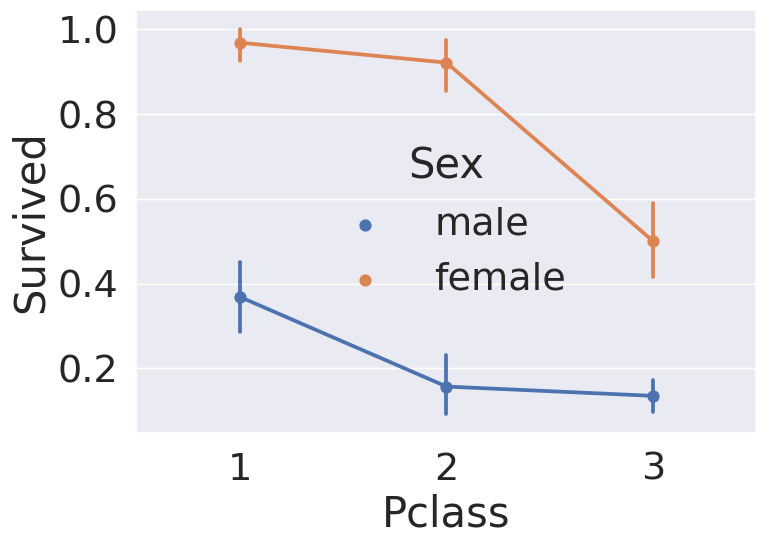

In [21]:
sns.pointplot(df_train, x='Pclass', y='Survived', hue='Sex')

- 모든 클래스에서 female이 살 확률이 male보다 높은 걸 알 수 있습니다.
- 또한 남자, 여자 상관없이 클래스가 높을 수록 살 확률이 높습니다.
- 위 그래프는 hue 대신 column으로 하면 아래와 같아집니다.

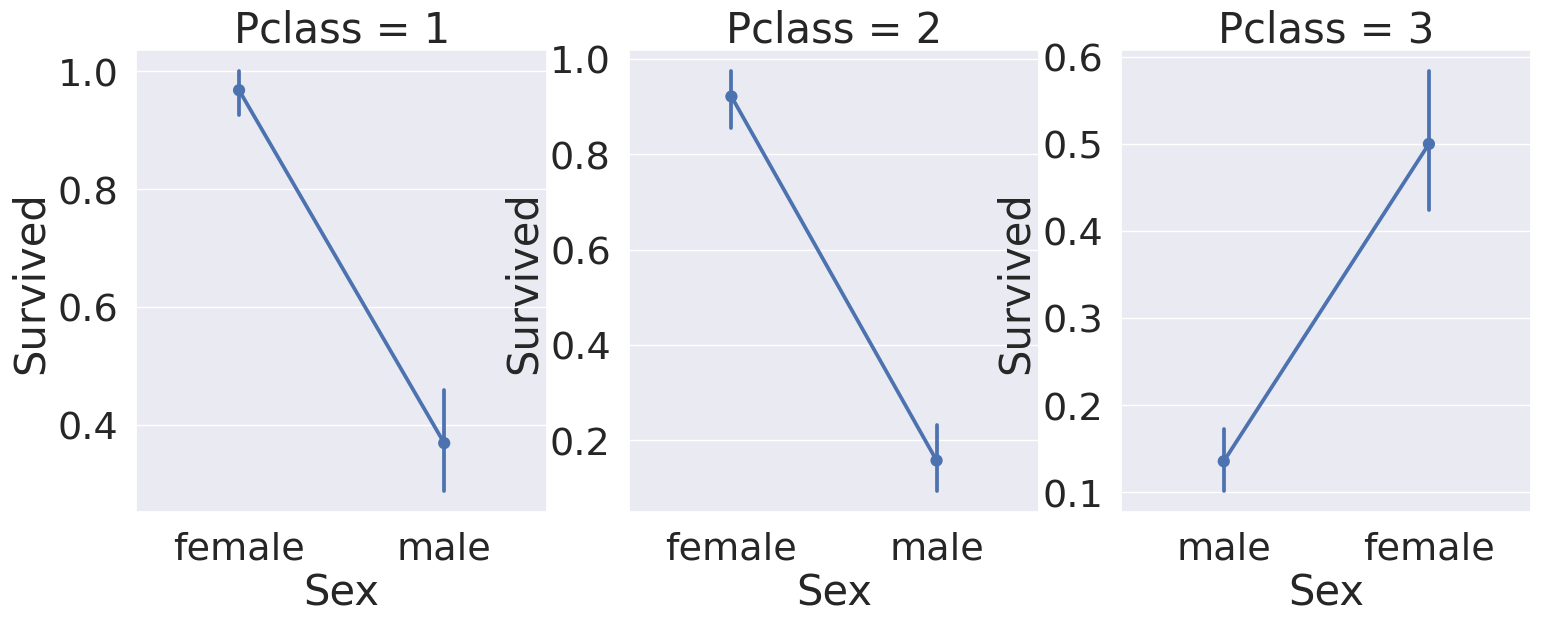

In [22]:
f, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.pointplot(df_train[df_train['Pclass'] == 1], x='Sex', y='Survived', ax=ax[0])
ax[0].set_title('Pclass = 1')
sns.pointplot(df_train[df_train['Pclass'] == 2], x='Sex', y='Survived', ax=ax[1])
ax[1].set_title('Pclass = 2')
sns.pointplot(df_train[df_train['Pclass'] == 3], x='Sex', y='Survived', ax=ax[2])
ax[2].set_title('Pclass = 3')
plt.show()

### 2.4 Age
- 이번에는 Age feature를 살펴봅시다.

In [23]:
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))

제일 나이 많은 탑승객 : 80.0 Years
제일 어린 탑승객 : 0.4 Years
탑승객 평균 나이 : 29.7 Years


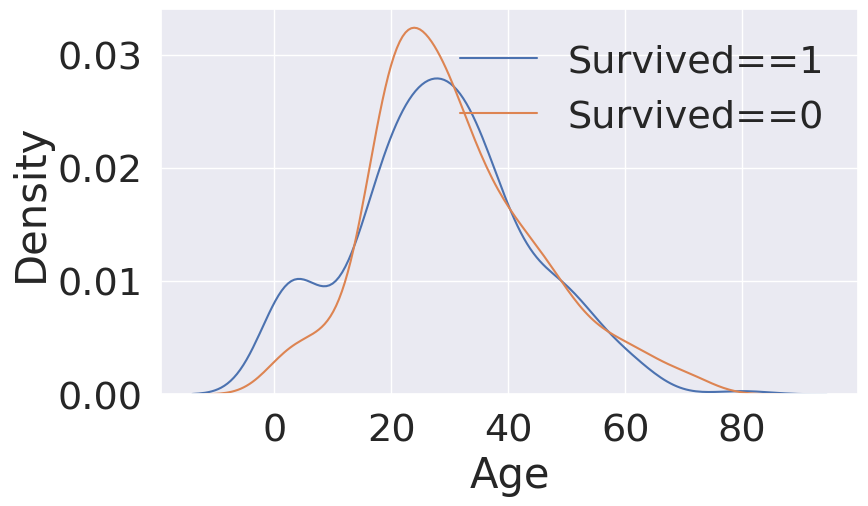

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['Survived']==1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived']==0]['Age'], ax=ax)
plt.legend(['Survived==1', 'Survived==0'])
plt.show()

- 보시다시피, 생존자 중 나이가 어린 경우가 많음을 볼 수 있습니다.

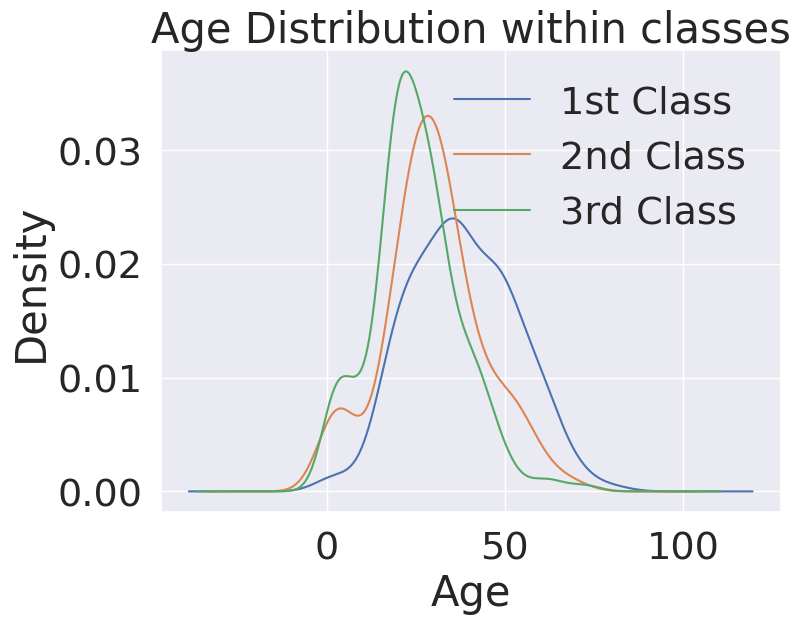

In [25]:
# Age distribution withing classes
plt.figure(figsize=(8, 6))
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

- Class가 높을 수록 나이 많은 사람의 비중이 커짐
- 나이대가 변하면서 생존률이 어떻게 되는 지 보려고 합니다.
- 나이범위를 점점 넓혀가며, 생존률이 어떻게 되는지 한번 봅시다.

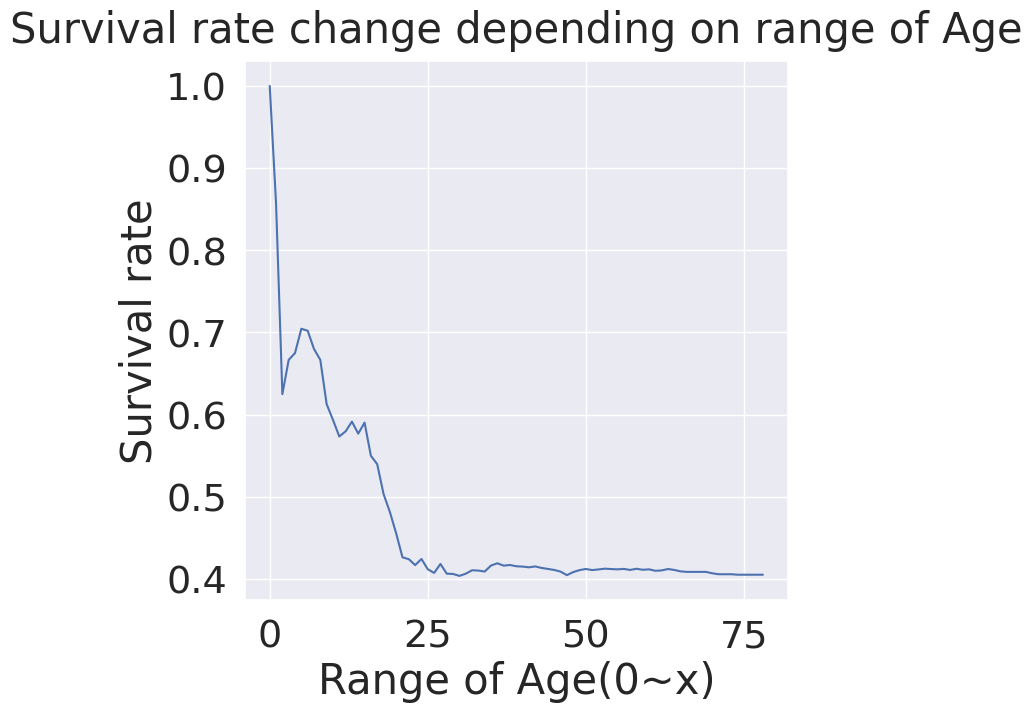

In [26]:
cummulate_survived_ratio = []
for i in range(1, 80) :
    cummulate_survived_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / 
                                   len(df_train[df_train['Age'] < i]['Survived']))

plt.figure(figsize=(7, 7))
plt.plot(cummulate_survived_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

- 보시다시피, 나이가 어릴수록 생존률이 확실히 높은 것을 확인할 수 있습니다.
- 우리는 이 나이가 중요한 feature로 쓰일 수 있음을 확인했습니다.

Pclass, Sex, Age

- 지금까지 본, Sex, Pclass, Age, Survived 모두에 대해서 보고 싶습니다. 이를 쉽게 그려주는 것이 seaborn의 violinplot 입니다.
- x축은 우리가 나눠서 보고 싶어하는 case(여기선 Pclass, Sex)를 나타내고, y축은 보고 싶어하는 distribution(Age) 입니다.
- 한 번 그려보겠습니다.

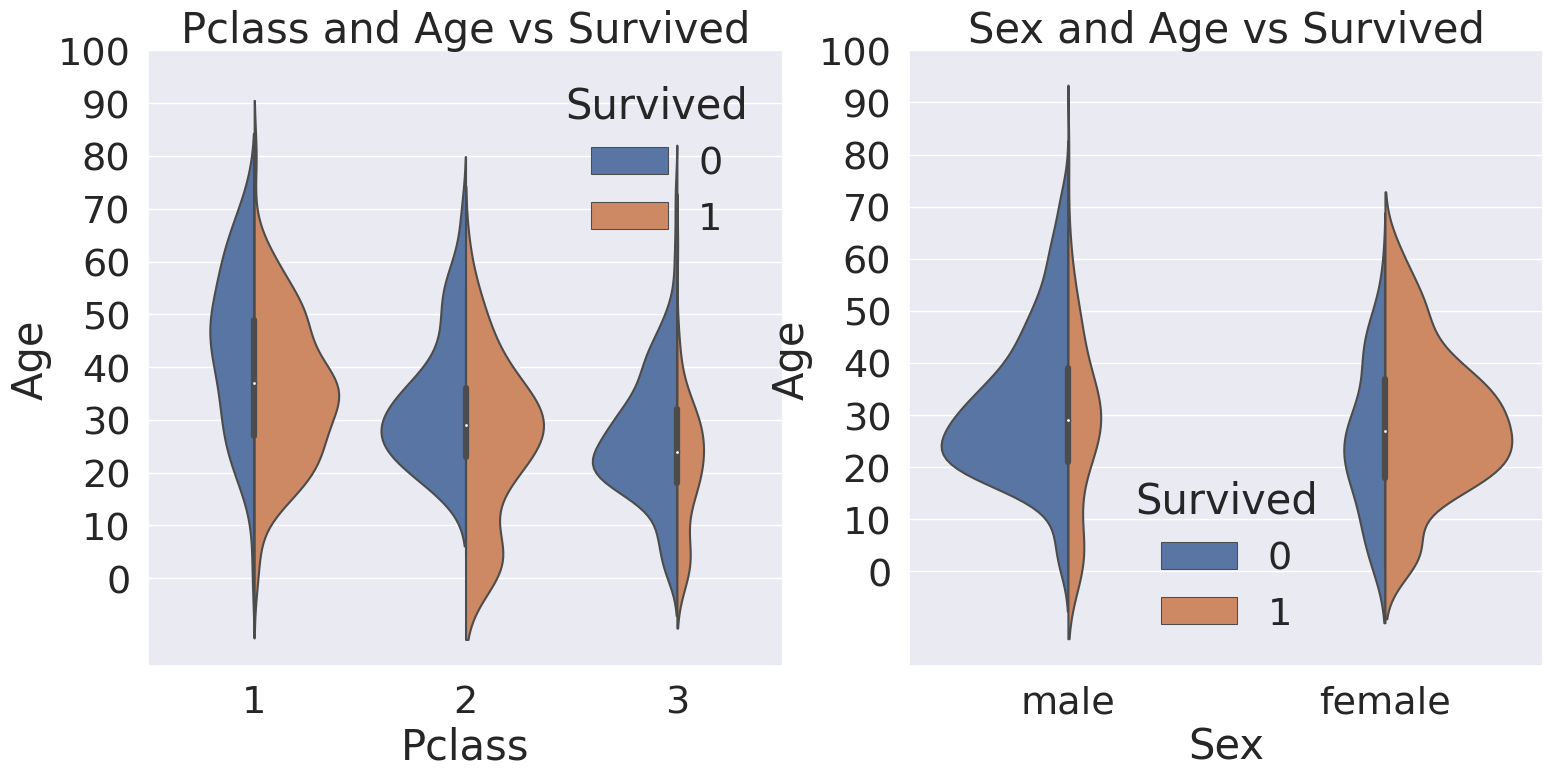

In [27]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot(x='Pclass', y='Age', hue='Survived', 
               data=df_train, scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot(data=df_train, x='Sex', y='Age', hue='Survived', 
              scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
plt.show()

- 왼쪽 그림은 Pclass 별로 Age의 distribution이 어떻게 다른지, 거기에 생존여부에 따라 구분한 그래프입니다.
- 오른쪽 그림도 마찬가지 Sex, 생존에 따른 distribution이 어떻게 다른지 보여주는 그래프입니다.
- 생존만 봤을 때, 모든 클래스에서 나이가 어릴 수록 생존을 많이 한 것을 볼 수 있습니다.
- 오른쪽 그림을 보면, 명확히 여자가 생존을 많이 한 것을 볼 수 있습니다.
- 여성과 아이를 먼저 챙긴 것을 볼 수 있습니다.

### 2.6 Embarked
- Embarked는 탑승한 항구를 나타냅니다.
- 위에서 해왔던 것과 비슷하게 탑승한 곳에 따른 생존률을 보겠습니다.

<Axes: xlabel='Embarked'>

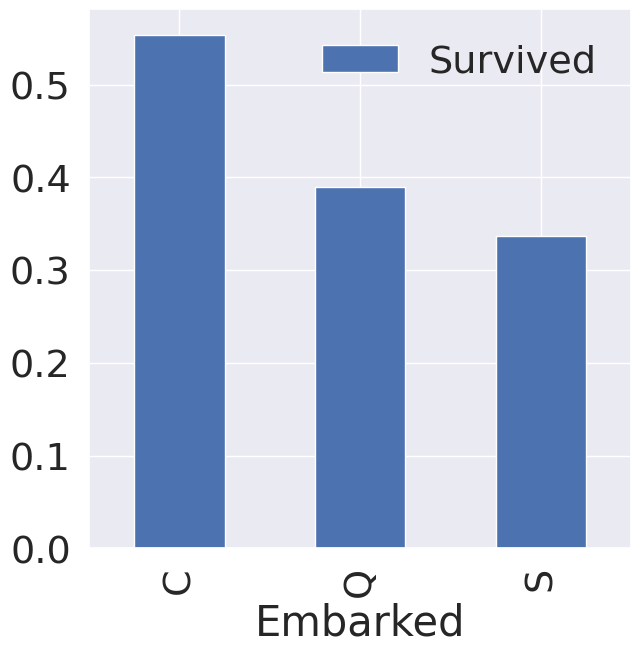

In [28]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)

- 보시다시피, 조금의 차이는 있지만 생존률은 좀 비슷한 거 같습니다. 그래도 C가 제일 높군요.
- 모델에 얼마나 큰 영향을 미칠지는 모르겠지만, 그래도 사용하겠습니다.
- 사실, 모델을 만들고 나면 우리가 사용한 feature들이 얼마나 중요한 역할을 했는지 확인해볼 수 있습니다. 이는 추후에 모델을 만들고 난 다음에 살펴볼 것입니다.
- 다른 feature로 split하여 한 번 살펴보겠습니다.

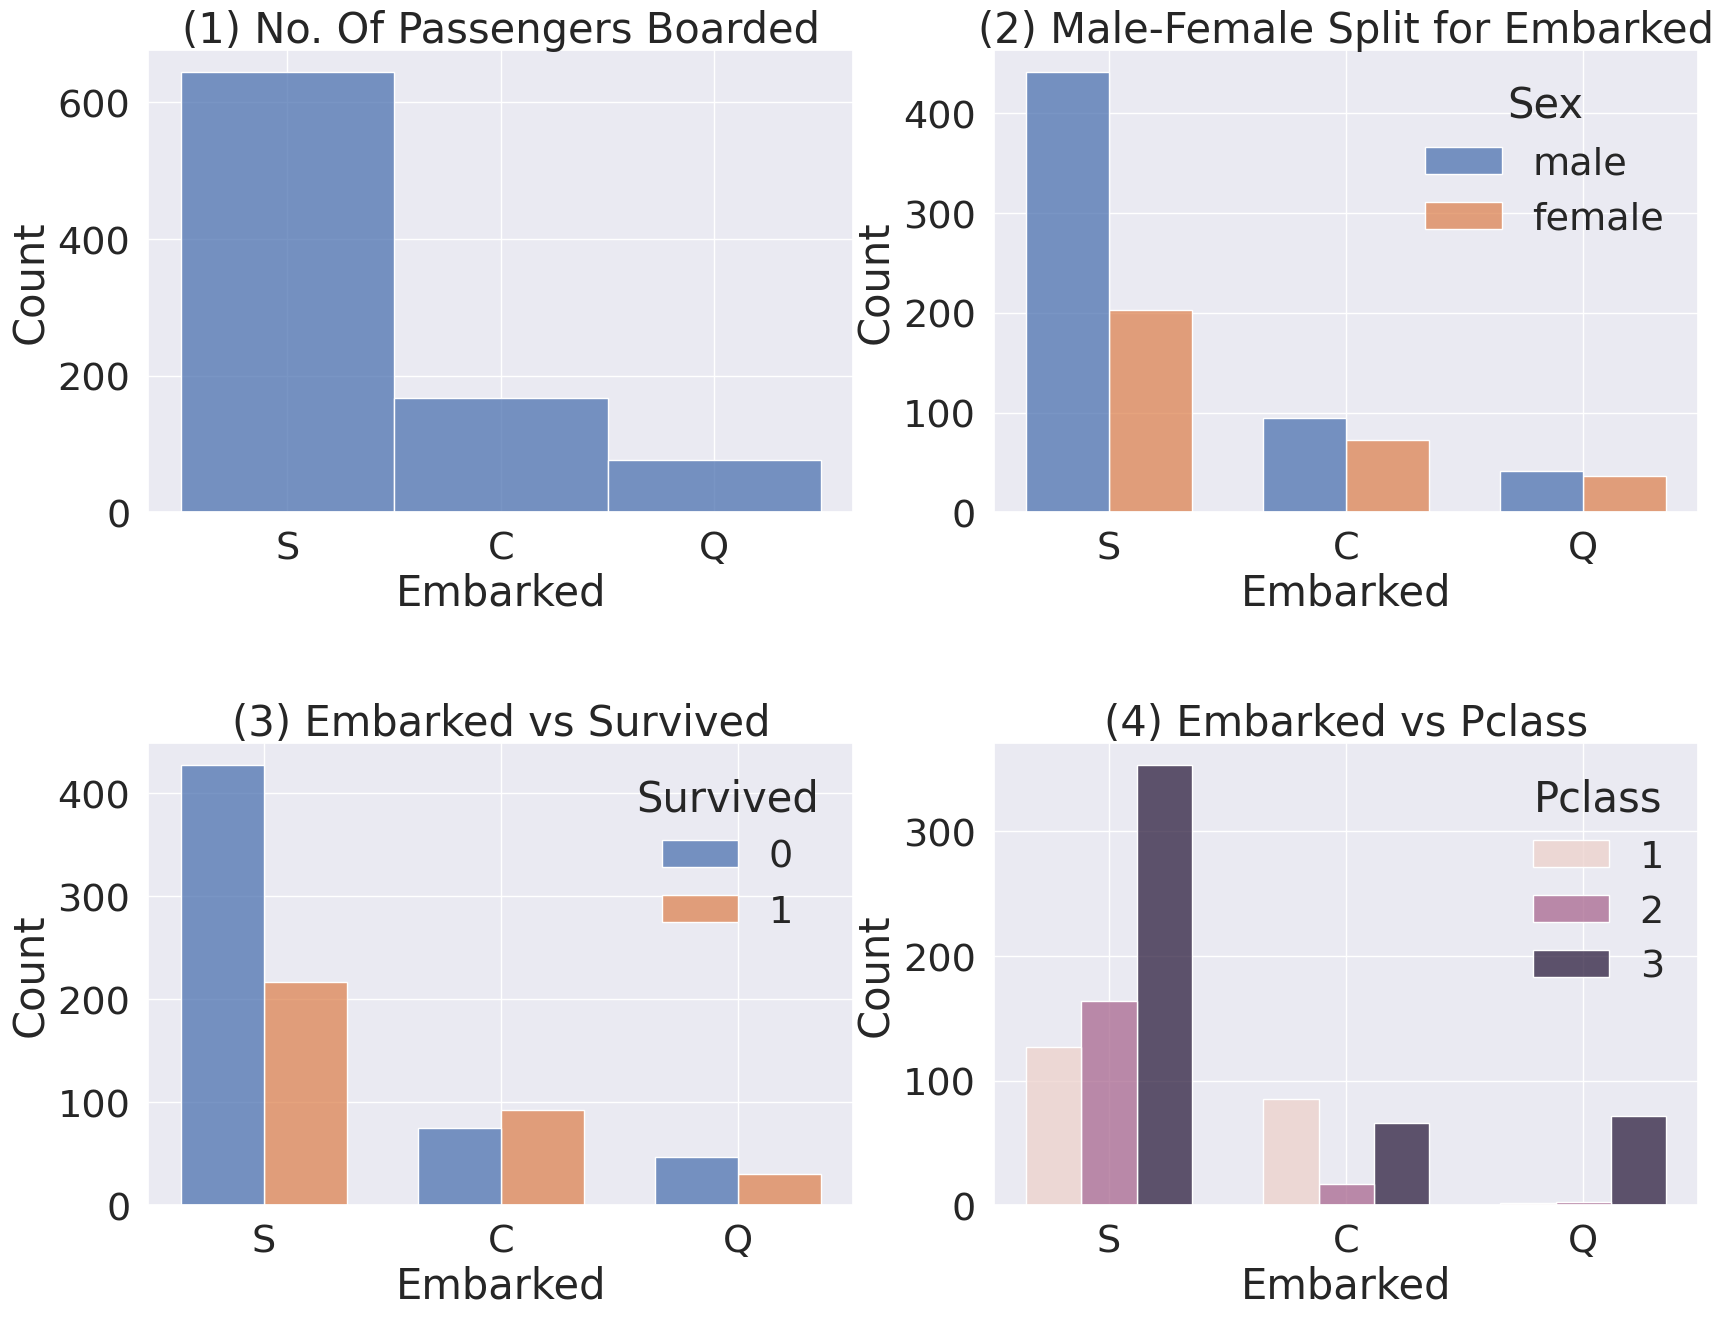

In [29]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))
sns.histplot(data=df_train, x='Embarked', ax=ax[0, 0])
ax[0, 0].set_title('(1) No. Of Passengers Boarded')
sns.histplot(data=df_train, x='Embarked', hue='Sex', shrink=0.7, multiple='dodge', ax=ax[0, 1])
ax[0, 1].set_title('(2) Male-Female Split for Embarked')
sns.histplot(data=df_train, x='Embarked', hue='Survived', shrink=0.7, multiple='dodge', ax=ax[1, 0])
ax[1, 0].set_title('(3) Embarked vs Survived')
sns.histplot(data=df_train, x='Embarked', hue='Pclass', shrink=0.7, multiple='dodge', ax=ax[1, 1])
ax[1, 1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Figure(1) - 전체적으로 봤을 때, S에서 가장 많은 사람이 탑승했습니다.
- Figure(2) - C와 Q는 남녀의 비율이 비슷하고, S는 남자가 더 많습니다.
- Figure(3) - 생존확률이 S 경우 많이 낮은 걸 볼 수 있습니다. (이전 그래프에서 봤었습니다.)
- Figure(4) - Class로 split해서 보니, C가 생존확률이 높은 건 클래스가 높은 사람이 많이 타서 그렇습니다. S는 3rd class가 많아서 생존확률이 낮게 나옵니다.

### 2.7 Family - SibSp(형제 자매) + Parch(부모, 자녀)
- SibSp와 Parch를 합하면 Family가 될 것입니다. Family로 합쳐서 분석해봅시다.

In [30]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야 하니 1을 더합니다.
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야 하니 1을 더합니다.

In [31]:
print('Maximum size of Family: ', df_train['FamilySize'].max())
print('Minimum size of Family: ', df_train['FamilySize'].min())

Maximum size of Family:  11
Minimum size of Family:  1


- FamilySize와 생존의 관계를 한번 살펴봅시다.

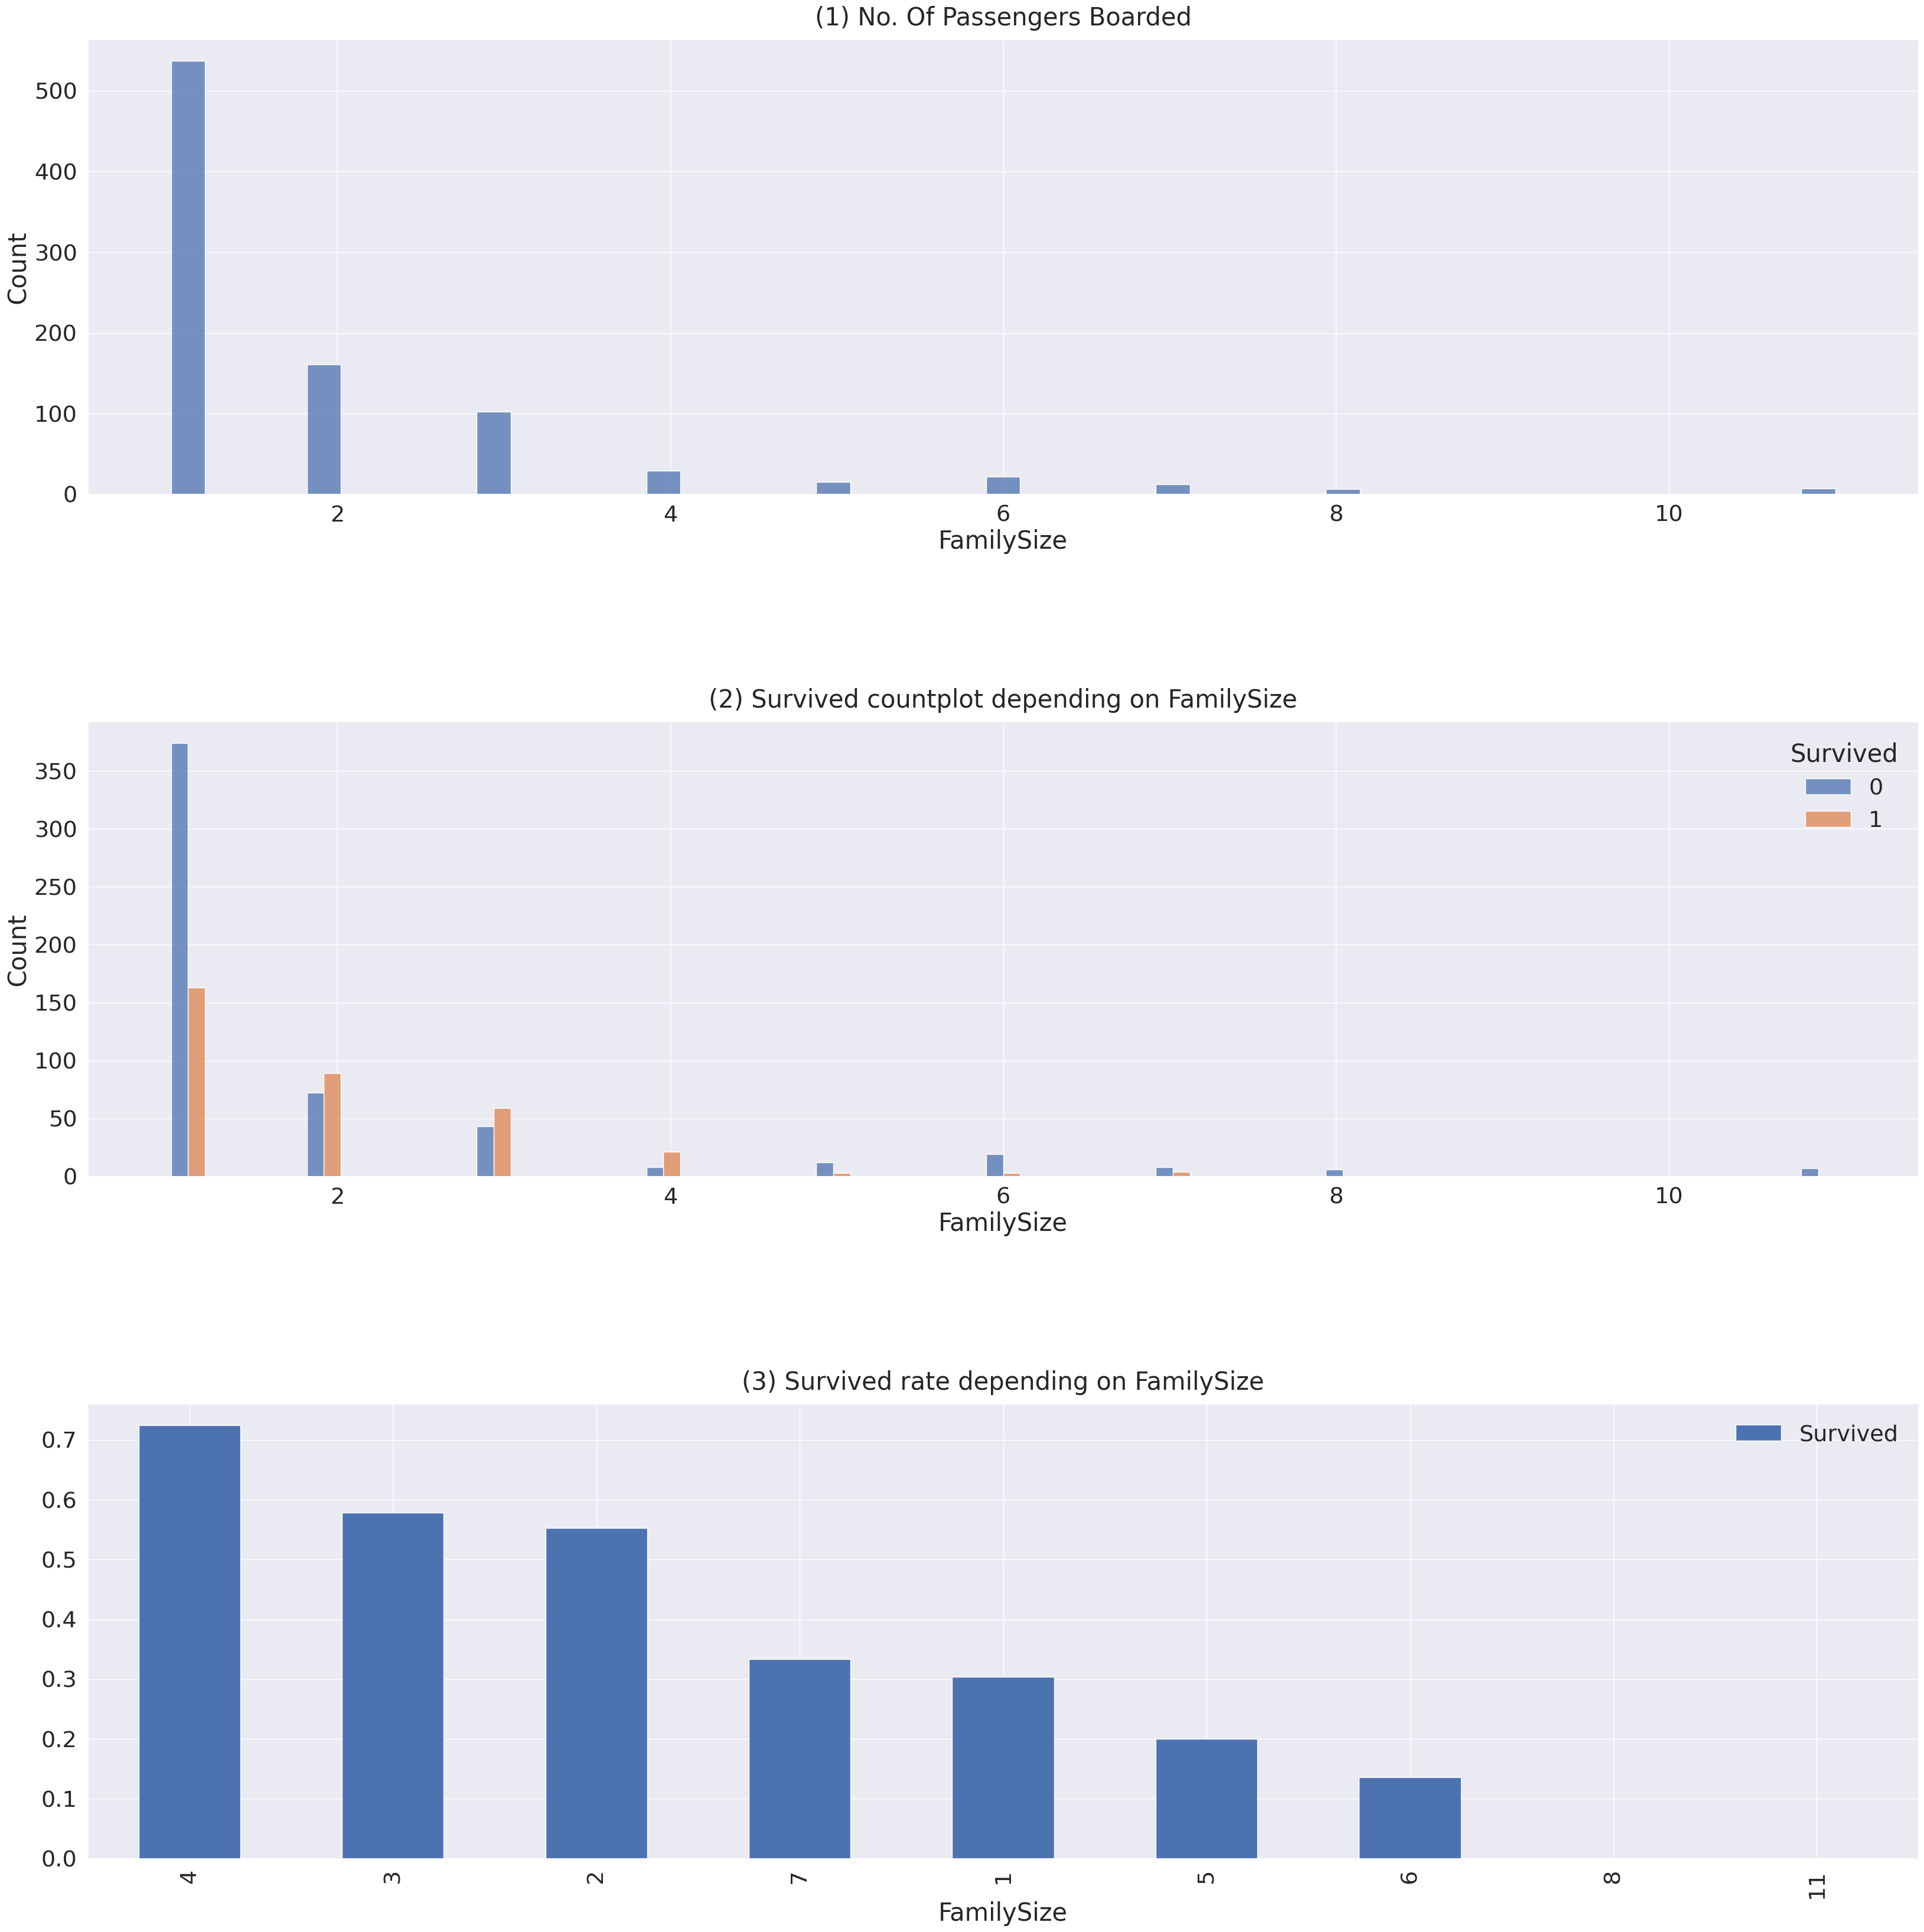

In [32]:
f, ax = plt.subplots(3, 1, figsize=(40, 40))
sns.histplot(data=df_train, x='FamilySize', ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)

sns.histplot(data=df_train, x='FamilySize', hue='Survived', multiple='dodge', ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize', y=1.02)

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize', y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Figure (1) - 가족 크기가 1~11까지 있음을 볼 수 있습니다. 대부분 1명이고 그 다음으로 2, 3,4명입니다.
- Figure (2), (3) - 가족 크기에 따른 생존비교입니다. 가족이 4명인 경우가 가장 생존 확률이 높습니다. 가족수가 많아질수록, (5, 6, 7, 8, 11) 생존확률이 낮아지네요. 가족수가 너무 작아도 (1), 너무 커도(5, 6, 7, 8, 11) 생존 확률이 적네요. 3~4명 선에서 생존 확률이 높은 걸 확인할 수 있습니다.

### 2.8 Fare
- Fare는 탑승요금이며, continuous feature입니다. 한 번 histogram을 그려보겠습니다.

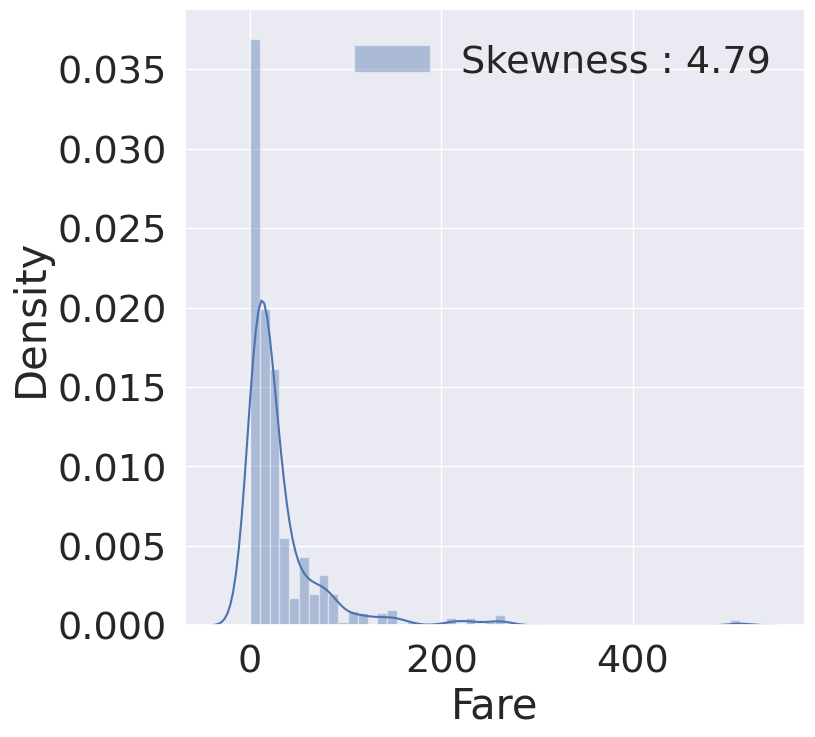

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

- 보시다시피, distribution이 매우 비대칭인 것을 알 수 있습니다. (high skewness). 만약 이대로 모델에 넣어준다면 자칫 모델이 학습할 수도 있습니다. 몇 개 없는 outlier에 대해서 너무 민감하게 반응한다면, 실제 예측 시에 좋지 못한 결과를 부를 수 있습니다.
- outlier의 영향을 줄이기 위해 Fare에 log를 취하겠습니다.
- 여기서 우리는 pandas의 유용한 기능을 사용할 겁니다. dataframe의 특정 columns에 공통된 작업(함수)를 적용하고 싶으면 아래의 map, 또는 apply를 사용하면 매우 손쉽게 적용할 수 있습니다.
- 우리가 지금 원하는 것은 Fare columns의 데이터 모두를 log값 취하는 것인데, 파이썬의 간단한 lambda 함수를 이용해 간단한 로그를 적용하는 함수를 map에 인수로 넣어주면, Fare columns 데이터에 그대로 적용이 됩니다. 매우 유용한 기능이니 꼭 숙지하세요!

In [34]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() # testset에 있는 nan value를 평균값으로 치환합니다.

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

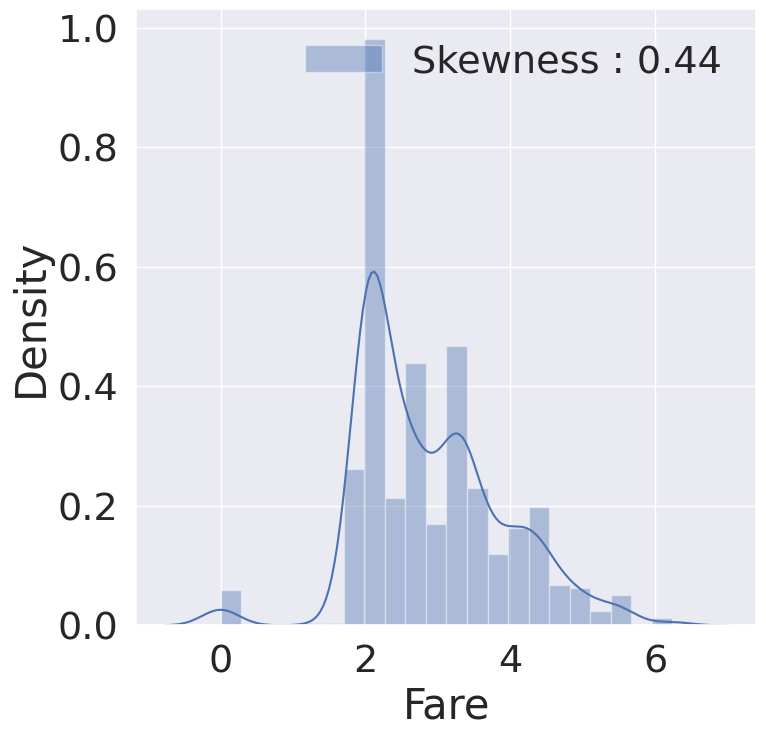

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

- log를 취하니, 이제 비대칭성이 많이 사라진 것을 볼 수 있습니다.
- 우리는 이런 작업을 사용해 모델이 좀 더 좋은 성능을 내도록 할 수 있습니다.
- 사실 방금한 것은 feature engineering에 들어가는 부분인데, 여기서 작업했습니다.
- 모델을 학습시키기 위해, 그리고 그 모델의 성능을 높이기 위해 feature들을 여러 조작을 가하거나, 새로운 feature를 추가하는 것을 feature engineering 이라고 하는데, 우리는 이제 그것을 살펴볼 것입니다.

### 2.9 Cabin
- 이 feature는 NaN이 대략 80%이므로, 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지는 않습니다.
- 그러므로 우리가 세우려는 모델에 포함시키지 않도록 하겠습니다.

### 2.10 Ticket
- 이 feature는 NaN은 없습니다. 일단 string data이므로 우리가 어떤 작업들을 해주어야 실제 모델에 사용할 수 있는데, 이를 위해선 사실 아이디어가 필요합니다.

In [36]:
df_train['Ticket'].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

- 보시다시피, ticket number는 매우 다양합니다. 우리는 여기서 어떤 특징을 이끌어내서 생존과 연결시킬 수 있을까요?
- 여러분이 직접 한 번 아이디어를 내보세요! 이것이 본격적인 캐글 레이스의 시작점입니다.